In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, LSTM, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Set a seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the input shape and number of classes
input_shape = (224, 224, 3)  # VGG16 uses 224x224 input size
num_classes = 3

# Function to extract features using VGG16 model
def extract_features(generator, base_model):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * generator.batch_size >= len(generator.filenames):
            break
    return np.concatenate(features), np.concatenate(labels)

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define data directories
base_dir = r'C:\Users\D E L L\Downloads\SPORTS ACTION RECOGNITION PROJECT FOLDER\naik dataset'
train_data_dir = os.path.join(base_dir, r'C:\Users\D E L L\Downloads\SPORTS ACTION RECOGNITION PROJECT FOLDER\naik dataset\train')
test_data_dir = os.path.join(base_dir, r'C:\Users\D E L L\Downloads\SPORTS ACTION RECOGNITION PROJECT FOLDER\naik dataset\test')

# Define data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Extract features using VGG16 model for training and testing data
train_features, train_labels = extract_features(train_generator, base_model)
test_features, test_labels = extract_features(test_generator, base_model)

# Reshape the features for LSTM input
train_features = train_features.reshape(train_features.shape[0], 1, train_features.shape[1], train_features.shape[2], train_features.shape[3])
test_features = test_features.reshape(test_features.shape[0], 1, test_features.shape[1], test_features.shape[2], test_features.shape[3])

# Define the overall model combining CNN and LSTM
def build_model(input_shape, lstm_units, num_classes):
    inputs = Input(shape=input_shape)
    x = TimeDistributed(GlobalAveragePooling2D())(inputs)
    x = TimeDistributed(Dense(4096, activation='relu'))(x)
    x = Dropout(0.5)(x)
    x = TimeDistributed(Dense(4096, activation='relu'))(x)
    x = Dropout(0.5)(x)
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = LSTM(lstm_units, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Define model parameters
lstm_units = 256

# Build and compile the model
model = build_model((1, train_features.shape[2], train_features.shape[3], train_features.shape[4]), lstm_units, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Train the model
history = model.fit(
    train_features, train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(test_features, test_labels),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Get predictions on test data
y_pred = model.predict(test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print the metrics
print(f" Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Save the model
model.save("action_prediction_model_vgg16.keras")

Found 1119 images belonging to 3 classes.
Found 381 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━

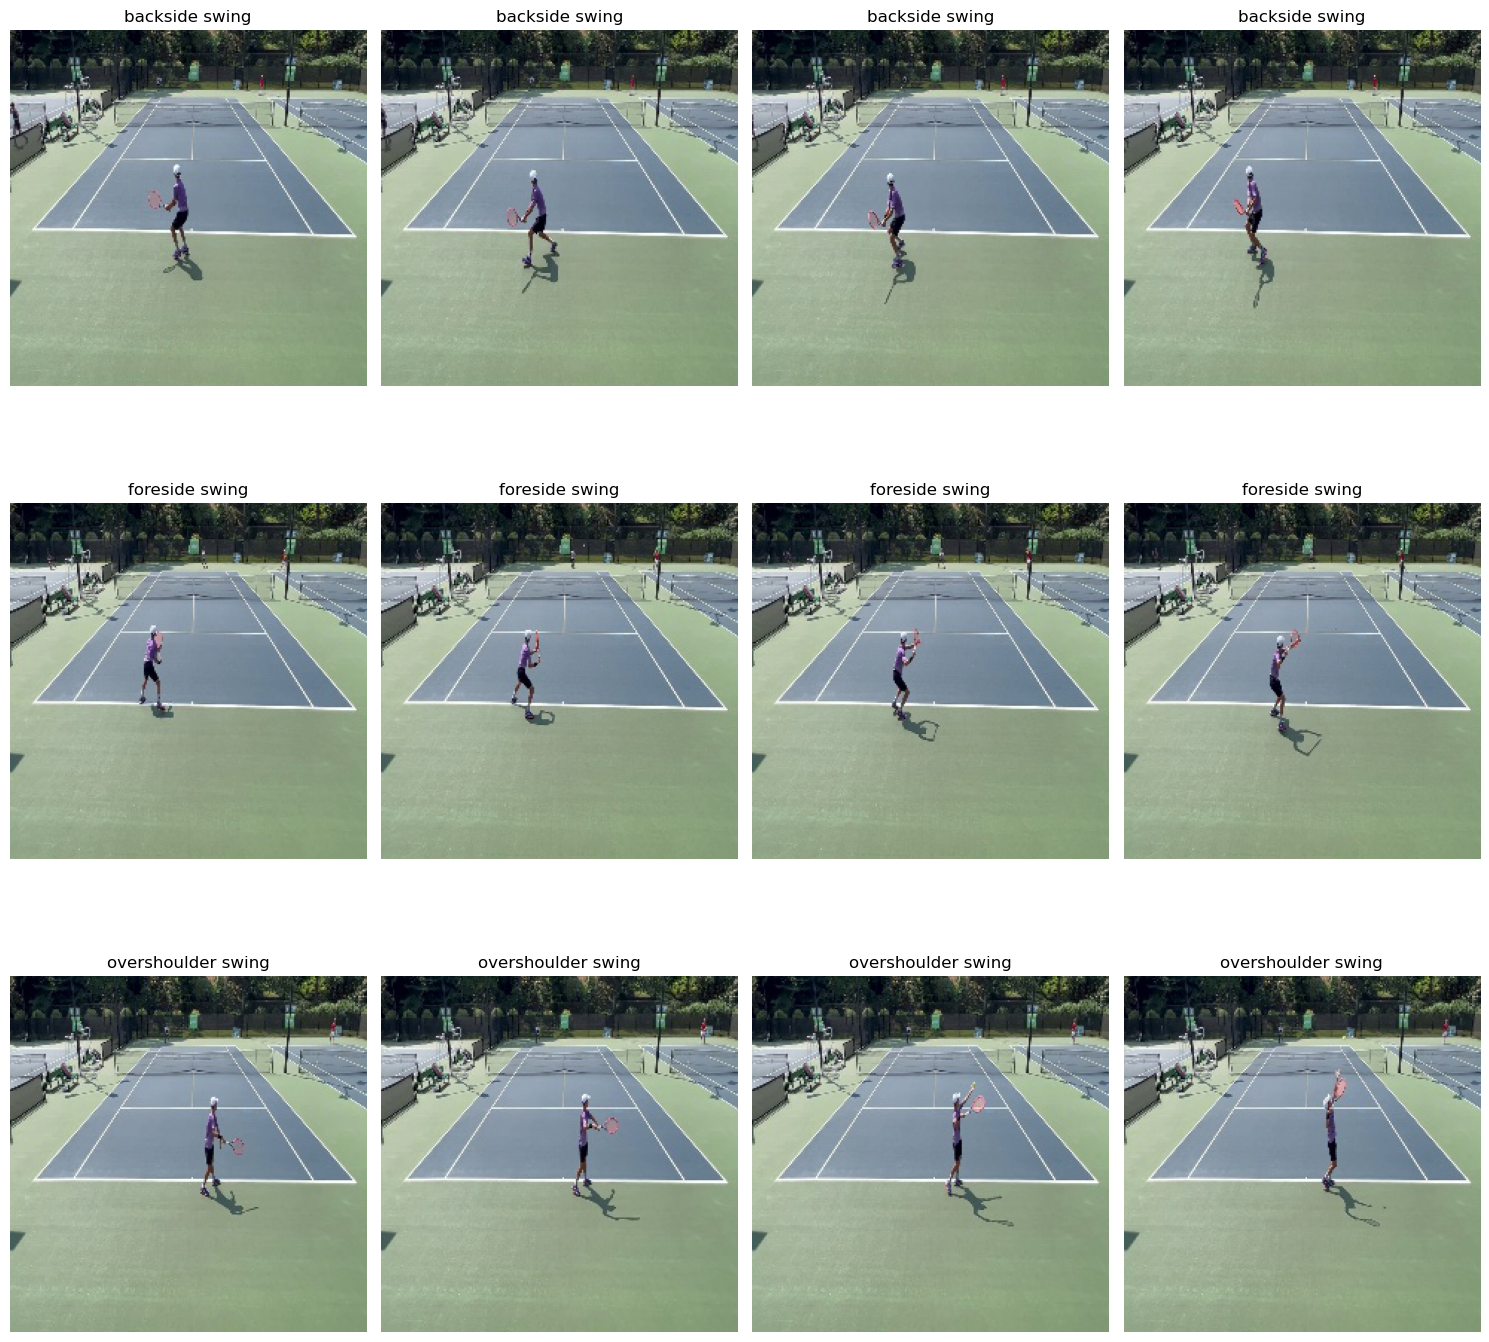

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Get filenames and true labels from the testing generator
filenames = test_generator.filenames
true_labels = test_generator.classes

# Define class names based on the order of classes in your dataset
class_names = list(test_generator.class_indices.keys())

# Dictionary to store the count of displayed images for each class
class_display_count = {class_name: 0 for class_name in class_names}

# Number of images to display from each class
num_images_per_class = 4

# Initialize subplot indices
subplot_index = 1

# Display the true labels for the testing images
plt.figure(figsize=(15, 15))

for i in range(len(filenames)):
    class_name = class_names[true_labels[i]]
    if class_display_count[class_name] < num_images_per_class:
        img_path = os.path.join(test_data_dir, filenames[i])
        img = plt.imread(img_path)
        plt.subplot(len(class_names), num_images_per_class, subplot_index)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
        class_display_count[class_name] += 1
        subplot_index += 1
        
        # Check if we have displayed required number of images for the current class
        if all(count >= num_images_per_class for count in class_display_count.values()):
            break

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
from tabulate import tabulate

# Data for the models and time steps
data = {
    'Method': [
        'InceptionV3 LSTM', 'InceptionV3 Historical LSTM (τ = 2)', 'InceptionV3 Historical LSTM (τ = 3)', 'InceptionV3 Historical LSTM (τ = 4)', 'InceptionV3 Historical LSTM (τ = 5)',
        'ResNet50 LSTM', 'ResNet50 Historical LSTM (τ = 2)', 'ResNet50 Historical LSTM (τ = 3)', 'ResNet50 Historical LSTM (τ = 4)', 'ResNet50 Historical LSTM (τ = 5)',
        'VGG16 LSTM', 'VGG16 Historical LSTM (τ = 2)', 'VGG16 Historical LSTM (τ = 3)', 'VGG16 Historical LSTM (τ = 4)', 'VGG16 Historical LSTM (τ = 5)'
    ],
    'Accuracy': [
        0.65, 0.79, 0.67, 0.67, 0.62,
        0.69, 0.72, 0.73, 0.74, 0.77,
        0.62, 0.82, 0.66, 0.66, 0.67
    ]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Filter DataFrames for each model
df_inception = df[df['Method'].str.contains('InceptionV3')]
df_resnet50 = df[df['Method'].str.contains('ResNet50')]
df_vgg16 = df[df['Method'].str.contains('VGG16')]

# Find the best accuracy for each model
best_inception = df_inception.loc[df_inception['Accuracy'].idxmax()]
best_resnet50 = df_resnet50.loc[df_resnet50['Accuracy'].idxmax()]
best_vgg16 = df_vgg16.loc[df_vgg16['Accuracy'].idxmax()]

# Combine the best results into a single DataFrame
best_df = pd.DataFrame([best_inception, best_resnet50, best_vgg16])

# Display the best accuracies using tabulate
print(tabulate(best_df, headers='keys', tablefmt='grid'))


+----+-------------------------------------+------------+
|    | Method                              |   Accuracy |
+====+=====================================+============+
|  1 | InceptionV3 Historical LSTM (τ = 2) |       0.79 |
+----+-------------------------------------+------------+
|  9 | ResNet50 Historical LSTM (τ = 5)    |       0.77 |
+----+-------------------------------------+------------+
| 11 | VGG16 Historical LSTM (τ = 2)       |       0.82 |
+----+-------------------------------------+------------+


+----+-------------------------------------+------------+
|    | Method                              |   Accuracy |
+====+=====================================+============+
|  1 | InceptionV3 Historical LSTM (τ = 2) |       0.79 |
+----+-------------------------------------+------------+
|  9 | ResNet50 Historical LSTM (τ = 5)    |       0.77 |
+----+-------------------------------------+------------+
| 11 | VGG16 Historical LSTM (τ = 2)       |       0.82 |
+----+-------------------------------------+------------+


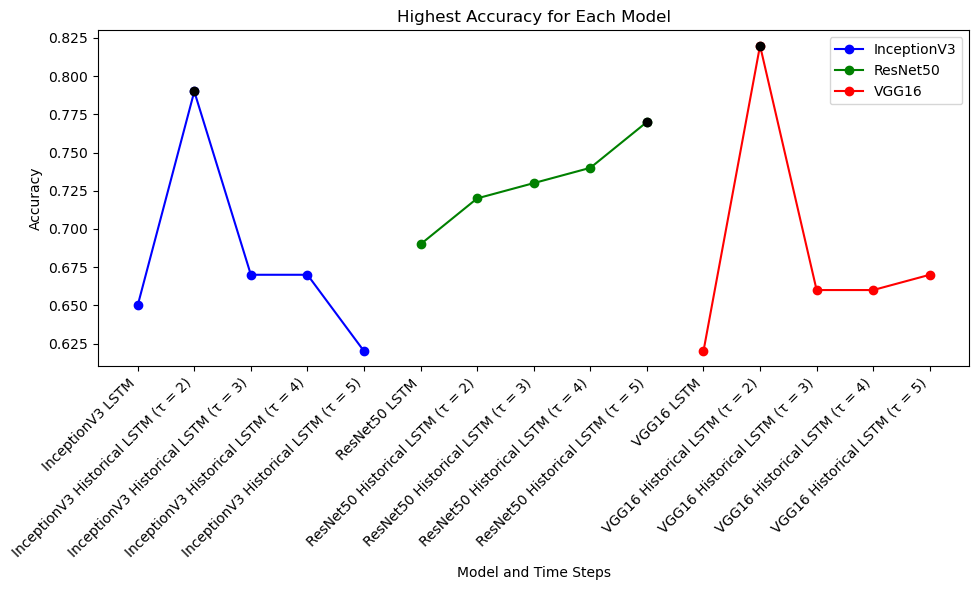

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Data for the models and time steps
data = {
    'Method': [
        'InceptionV3 LSTM', 'InceptionV3 Historical LSTM (τ = 2)', 'InceptionV3 Historical LSTM (τ = 3)', 'InceptionV3 Historical LSTM (τ = 4)', 'InceptionV3 Historical LSTM (τ = 5)',
        'ResNet50 LSTM', 'ResNet50 Historical LSTM (τ = 2)', 'ResNet50 Historical LSTM (τ = 3)', 'ResNet50 Historical LSTM (τ = 4)', 'ResNet50 Historical LSTM (τ = 5)',
        'VGG16 LSTM', 'VGG16 Historical LSTM (τ = 2)', 'VGG16 Historical LSTM (τ = 3)', 'VGG16 Historical LSTM (τ = 4)', 'VGG16 Historical LSTM (τ = 5)'
    ],
    'Accuracy': [
        0.65, 0.79, 0.67, 0.67, 0.62,
        0.69, 0.72, 0.73, 0.74, 0.77,
        0.62, 0.82, 0.66, 0.66, 0.67
    ]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Filter DataFrames for each model
df_inception = df[df['Method'].str.contains('InceptionV3')]
df_resnet50 = df[df['Method'].str.contains('ResNet50')]
df_vgg16 = df[df['Method'].str.contains('VGG16')]

# Find the best accuracy for each model
best_inception = df_inception.loc[df_inception['Accuracy'].idxmax()]
best_resnet50 = df_resnet50.loc[df_resnet50['Accuracy'].idxmax()]
best_vgg16 = df_vgg16.loc[df_vgg16['Accuracy'].idxmax()]

# Combine the best results into a single DataFrame
best_df = pd.DataFrame([best_inception, best_resnet50, best_vgg16])

# Display the best accuracies using tabulate
print(tabulate(best_df, headers='keys', tablefmt='grid'))

# Plot the highest accuracies using a line plot
plt.figure(figsize=(10, 6))
plt.plot(df_inception['Method'], df_inception['Accuracy'], marker='o', linestyle='-', label='InceptionV3', color='blue')
plt.plot(df_resnet50['Method'], df_resnet50['Accuracy'], marker='o', linestyle='-', label='ResNet50', color='green')
plt.plot(df_vgg16['Method'], df_vgg16['Accuracy'], marker='o', linestyle='-', label='VGG16', color='red')

# Highlight the best accuracies
plt.scatter(best_df['Method'], best_df['Accuracy'], color='black', zorder=5)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Model and Time Steps')
plt.ylabel('Accuracy')
plt.title('Highest Accuracy for Each Model')
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, LSTM, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

# Set a seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the input shape and number of classes
input_shape = (299, 299, 3)  # VGG16 uses 224x224 input size, but we'll keep 299x299 as in your code
num_classes = 3  # Adjust if necessary

# Define data directories
base_dir = r'C:\Users\D E L L\Downloads\SPORTS ACTION RECOGNITION PROJECT FOLDER\naik dataset'
train_data_dir = os.path.join(base_dir, r'C:\Users\D E L L\Downloads\SPORTS ACTION RECOGNITION PROJECT FOLDER\naik dataset\train')
test_data_dir = os.path.join(base_dir, r'C:\Users\D E L L\Downloads\SPORTS ACTION RECOGNITION PROJECT FOLDER\naik dataset\test')

# Function to extract features using VGG16 model
def extract_features(generator, base_model):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * generator.batch_size >= len(generator.filenames):
            break
    return np.concatenate(features), np.concatenate(labels)

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Extract features using VGG16 model for training and testing data
print("Extracting features...")
train_features, train_labels = extract_features(train_generator, base_model)
test_features, test_labels = extract_features(test_generator, base_model)

# Function to prepare data for different time steps
def prepare_data_for_lstm(features, labels, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps + 1):
        X.append(features[i:i+time_steps])
        y.append(labels[i+time_steps-1])
    return np.array(X), np.array(y)

# Define the historical LSTM model
def build_historical_lstm_model(input_shape, lstm_units, num_classes, time_steps):
    inputs = Input(shape=(time_steps,) + input_shape)
    x = TimeDistributed(GlobalAveragePooling2D())(inputs)
    x = TimeDistributed(Dense(512, activation='relu'))(x)
    x = Dropout(0.5)(x)
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = LSTM(lstm_units, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Define model parameters
lstm_units = 128
time_steps_list = [2, 3, 4, 5]
results = {}

for time_steps in time_steps_list:
    print(f"\nTraining model for {time_steps} time steps:")
    
    # Prepare data for LSTM
    print("Preparing data for LSTM...")
    X_train, y_train = prepare_data_for_lstm(train_features, train_labels, time_steps)
    X_test, y_test = prepare_data_for_lstm(test_features, test_labels, time_steps)

    # Build and compile the model
    print("Building and compiling the model...")
    model = build_historical_lstm_model(train_features.shape[1:], lstm_units, num_classes, time_steps)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_historical_lstm_model_{time_steps}_steps.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    # Train the model
    print("Training the model...")
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, model_checkpoint, reduce_lr]
    )

    # Evaluate the model
    print("Evaluating the model...")
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy = np.mean(y_true == y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    # Store the results
    results[time_steps] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    # Save the model
    model.save(f"historical_lstm_action_recognition_model_{time_steps}_steps.keras")
    print(f"Model for {time_steps} time steps saved successfully.")

# Print all results together
print("\nResults for all time steps:")
for time_steps, metrics in results.items():
    print(f"\nTime steps: {time_steps}")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"Precision: {metrics['precision']:.2f}")
    print(f"Recall: {metrics['recall']:.2f}")
    print(f"F1-score: {metrics['f1']:.2f}")

# Find the best performing model based on F1-score
best_time_steps = max(results, key=lambda k: results[k]['f1'])
best_metrics = results[best_time_steps]
print(f"\nBest performing model (based on F1-score):")
print(f"Time steps: {best_time_steps}")
print(f"Accuracy: {best_metrics['accuracy']:.2f}")
print(f"Precision: {best_metrics['precision']:.2f}")
print(f"Recall: {best_metrics['recall']:.2f}")
print(f"F1-score: {best_metrics['f1']:.2f}")

Found 1119 images belonging to 3 classes.
Found 381 images belonging to 3 classes.
Extracting features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s

In [1]:
import pandas as pd
from tabulate import tabulate

# Updated data for the models and time steps
data = {
    'Method': [
        'Historical LSTM (τ = 2)', 'Historical LSTM (τ = 3)', 'Historical LSTM (τ = 4)', 'Historical LSTM (τ = 5)', 
        'Inception LSTM (τ = 2)', 'Inception LSTM (τ = 3)', 'Inception LSTM (τ = 4)', 'Inception LSTM (τ = 5)', 
        'ResNet50 LSTM (τ = 2)', 'ResNet50 LSTM (τ = 3)', 'ResNet50 LSTM (τ = 4)', 'ResNet50 LSTM (τ = 5)', 
        'VGG16 LSTM (τ = 2)', 'VGG16 LSTM (τ = 3)', 'VGG16 LSTM (τ = 4)', 'VGG16 LSTM (τ = 5)'
    ],
    'Accuracy': [
        0.72, 0.73, 0.74, 0.77, 
        0.79, 0.67, 0.67, 0.62, 
        0.72, 0.73, 0.74, 0.77, 
        0.82, 0.66, 0.66, 0.67
    ],
    'Precision': [
        0.72, 0.73, 0.75, 0.78, 
        0.80, 0.68, 0.67, 0.67, 
        0.72, 0.73, 0.75, 0.78, 
        0.82, 0.70, 0.75, 0.79
    ],
    'Recall': [
        0.72, 0.73, 0.74, 0.77, 
        0.79, 0.67, 0.67, 0.62, 
        0.72, 0.73, 0.74, 0.77, 
        0.82, 0.66, 0.66, 0.67
    ],
    'F1 Score': [
        0.72, 0.71, 0.73, 0.77, 
        0.78, 0.65, 0.64, 0.60, 
        0.72, 0.71, 0.73, 0.77, 
        0.82, 0.62, 0.61, 0.67
    ],
    
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Filter DataFrames for each model
df_inception = df[df['Method'].str.contains('Inception')]
df_resnet50 = df[df['Method'].str.contains('ResNet50')]
df_vgg16 = df[df['Method'].str.contains('VGG16')]

# Display the DataFrames using tabulate
print("Inception LSTM Model:")
print(tabulate(df_inception, headers='keys', tablefmt='grid'))
print("\nResNet50 LSTM Model:")
print(tabulate(df_resnet50, headers='keys', tablefmt='grid'))
print("\nVGG16 LSTM Model:")
print(tabulate(df_vgg16, headers='keys', tablefmt='grid'))


Inception LSTM Model:
+----+------------------------+------------+-------------+----------+------------+
|    | Method                 |   Accuracy |   Precision |   Recall |   F1 Score |
+====+========================+============+=============+==========+============+
|  4 | Inception LSTM (τ = 2) |       0.79 |        0.8  |     0.79 |       0.78 |
+----+------------------------+------------+-------------+----------+------------+
|  5 | Inception LSTM (τ = 3) |       0.67 |        0.68 |     0.67 |       0.65 |
+----+------------------------+------------+-------------+----------+------------+
|  6 | Inception LSTM (τ = 4) |       0.67 |        0.67 |     0.67 |       0.64 |
+----+------------------------+------------+-------------+----------+------------+
|  7 | Inception LSTM (τ = 5) |       0.62 |        0.67 |     0.62 |       0.6  |
+----+------------------------+------------+-------------+----------+------------+

ResNet50 LSTM Model:
+----+-----------------------+------------+

In [2]:
import pandas as pd
from tabulate import tabulate

# Updated data for the models and time steps
data = {
    'Method': [
        'VGG16 LSTM (τ = 2)', 'ResNet50 LSTM (τ = 5)', 'InceptionV3 Historical LSTM (τ = 2)'
    ],
    'Accuracy': [
        0.82, 0.77, 0.79
    ],
    'Precision': [
        0.82, 0.78, 0.80
    ],
    'Recall': [
        0.82, 0.77, 0.79
    ],
    'F1 Score': [
        0.82, 0.77, 0.78
    ],
    
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Display the table using tabulate
print(tabulate(df, headers='keys', tablefmt='grid'))


+----+-------------------------------------+------------+-------------+----------+------------+
|    | Method                              |   Accuracy |   Precision |   Recall |   F1 Score |
+====+=====================================+============+=============+==========+============+
|  0 | VGG16 LSTM (τ = 2)                  |       0.82 |        0.82 |     0.82 |       0.82 |
+----+-------------------------------------+------------+-------------+----------+------------+
|  1 | ResNet50 LSTM (τ = 5)               |       0.77 |        0.78 |     0.77 |       0.77 |
+----+-------------------------------------+------------+-------------+----------+------------+
|  2 | InceptionV3 Historical LSTM (τ = 2) |       0.79 |        0.8  |     0.79 |       0.78 |
+----+-------------------------------------+------------+-------------+----------+------------+
